# MTH686: Non-Linear Regression Project

## Import Libraries

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2, norm
import scipy.stats as stats
from scipy.optimize import curve_fit


## Load Data

In [39]:
try:
    df = pd.read_csv('set-34.dat', sep=r'\s+', header=None, names=['t', 'y'])
    t = df['t'].values
    y = df['y'].values.astype(np.float64)
    N_global = len(y)
    print(f"Loaded {N_global} data points.")
except FileNotFoundError:
    print("ERROR: Data file 'set-34.dat' not found.")
    exit()

Loaded 75 data points.


## General Gauss Newton Solver

In [40]:
def general_gauss_newton(t, y, model_func, jacobian_func, p0, max_iter=100, tol=1e-8):
    """
    Gauss-Newton algorithm for Non-Linear Least Squares.
    Returns estimated parameters, covariance, RSS, and iteration log.
    """
    theta_current = np.array(p0, dtype=float)
    P = len(p0)
    N = len(y)
    log_data = []

    initial_rss = np.sum((y - model_func(t, theta_current))**2)
    print(f"\nStarting Gauss-Newton (P={P}). Initial RSS: {initial_rss:.4f}")

    for iteration in range(max_iter):
        y_pred = model_func(t, theta_current)
        r = y - y_pred
        J = jacobian_func(t, theta_current)

        JT_J = J.T @ J
        JT_r = J.T @ r

        try:
            d_theta, _, _, _ = np.linalg.lstsq(JT_J, JT_r, rcond=None)
        except np.linalg.LinAlgError:
            print(f"Warning: Singularity at iteration {iteration}.")
            break

        theta_next = theta_current + d_theta
        step_size = np.linalg.norm(d_theta)

        log_data.append([iteration] + list(theta_current) + [np.sum(r**2)])

        if step_size < tol * (np.linalg.norm(theta_current) + tol):
            log_data.append([iteration+1] + list(theta_next) + [np.sum((y - model_func(t, theta_next))**2)])
            print(f"Gauss-Newton converged in {iteration+1} iterations.")
            theta_current = theta_next
            break

        theta_current = theta_next
    else:
        log_data.append([max_iter] + list(theta_current) + [np.sum((y - model_func(t, theta_current))**2)])
        print(f"Reached max iterations ({max_iter}).")

    # Covariance and RSS
    r_final = y - model_func(t, theta_current)
    RSS_final = np.sum(r_final**2)
    sigma2_hat = RSS_final / (N - P)
    try:
        J_final = jacobian_func(t, theta_current)
        JT_J_inv = np.linalg.inv(J_final.T @ J_final)
        pcov = sigma2_hat * JT_J_inv
    except np.linalg.LinAlgError:
        print("Warning: Covariance estimation failed.")
        pcov = np.full((P, P), np.nan)

    column_names = [f'θ{i}' for i in range(P)]
    log_df = pd.DataFrame(log_data, columns=['Iteration'] + column_names + ['RSS'])
    print(f"Final RSS: {RSS_final:.6f}")
    return theta_current, pcov, RSS_final, log_df

## Model Definitions

In [41]:
def model1_func(t, a0, a1, b1, a2, b2):
    return a0 + a1*np.exp(b1*t) + a2*np.exp(b2*t)

def model2_func(t, theta):
    a0, a1, b0, b1 = theta
    denominator = b0 + b1 * t
    return np.divide((a0 + a1 * t), denominator,
                     out=np.full_like(t, 1e10, dtype=np.float64),
                     where=np.abs(denominator) > 1e-12)

def model3_func(t, theta):
    b0, b1, b2, b3, b4 = theta
    return b0 + b1*t + b2*t**2 + b3*t**3 + b4*t**4

## Jacobian / Design Matrix Definitions

In [42]:
def jacobian_model1(t, theta):
    a0, a1, b1, a2, b2 = theta
    J = np.zeros((len(t), 5))
    J[:, 0] = 1
    J[:, 1] = np.exp(b1*t)
    J[:, 2] = a1 * t * np.exp(b1*t)
    J[:, 3] = np.exp(b2*t)
    J[:, 4] = a2 * t * np.exp(b2*t)
    return J

def jacobian_model2(t, theta):
    a0, a1, b0, b1 = theta
    J = np.zeros((len(t), 4))
    denom = b0 + b1 * t
    safe_denom = np.where(np.abs(denom) > 1e-12, denom, 1e10)
    safe_denom2 = safe_denom**2
    numerator = a0 + a1 * t
    J[:, 0] = 1.0 / safe_denom
    J[:, 1] = t / safe_denom
    J[:, 2] = - numerator / safe_denom2
    J[:, 3] = - (t * numerator) / safe_denom2
    return J

def design_matrix_model3(t):
    return np.vstack([np.ones_like(t), t, t**2, t**3, t**4]).T

## Initial guesses

In [43]:
p0_1 = [np.min(y), (np.max(y)-np.min(y)) / 2, -0.05, (np.max(y)-np.min(y)) / 2, -0.01]
p0_2 = [1.0, 0.1, 1.0, 0.01]

## Estimation

### Estimating Model 1
Using the curve_fit method which uses Gauss Newton method with damping

In [44]:
print("=== Model 1 Estimation ===")

popt1, pcov1 = curve_fit(model1_func, t, y, p0_1, maxfev=50000)
y_pred1 = model1_func(t, *popt1)
RSS1 = np.sum((y - y_pred1)**2)
print("Model 1 Parameters (a0, a1, b1, a2, b2):")
print(popt1)
print("Model 1 RSS:", RSS1)


=== Model 1 Estimation ===
Model 1 Parameters (a0, a1, b1, a2, b2):
[ 1.56013570e+00 -9.02479548e+01 -5.83225995e-02  8.87897161e+01
 -5.75994991e-02]
Model 1 RSS: 2.678461412246072


### Estimating Model 2
Using the explicitly defined Gauss Newton Method which is using the Jacobians which were defined above

In [45]:
print("=== Model 2 Estimation ===")
popt2, pcov2, RSS2, log_df2 = general_gauss_newton(t, y, model2_func, jacobian_model2, p0_2)
print("\n--- Model 2 Iteration History (Q2 Table) ---")
print(log_df2.round(6).to_markdown(index=False))

=== Model 2 Estimation ===

Starting Gauss-Newton (P=4). Initial RSS: 308.5558
Gauss-Newton converged in 27 iterations.
Final RSS: 3.247386

--- Model 2 Iteration History (Q2 Table) ---
|   Iteration |        θ0 |       θ1 |      θ2 |       θ3 |       RSS |
|------------:|----------:|---------:|--------:|---------:|----------:|
|           0 |  1        | 0.1      | 1       | 0.01     | 308.556   |
|           1 |  0.674263 | 0.141316 | 1.32141 | 0.029408 |  69.7848  |
|           2 |  0.296794 | 0.232637 | 1.50317 | 0.077979 |  18.9283  |
|           3 | -0.111978 | 0.388412 | 1.55495 | 0.170922 |   6.5213  |
|           4 | -0.271913 | 0.504483 | 1.50485 | 0.258193 |   3.52295 |
|           5 | -0.154383 | 0.498556 | 1.52648 | 0.267454 |   3.24768 |
|           6 | -0.141613 | 0.494852 | 1.52929 | 0.265681 |   3.24739 |
|           7 | -0.146148 | 0.496519 | 1.52816 | 0.266672 |   3.24739 |
|           8 | -0.143764 | 0.495645 | 1.52876 | 0.266151 |   3.24739 |
|           9 | -0.145

### Estimating Model 3
As the parameters are linear, this model has a closed form solution

In [46]:
print("=== Model 3 Estimation ===")
X3 = design_matrix_model3(t)
XtX_inv = np.linalg.inv(X3.T @ X3)
popt3 = XtX_inv @ X3.T @ y
y_pred3 = model3_func(t, popt3)
RSS3 = np.sum((y - y_pred3)**2)
sigma2_3 = RSS3 / (N_global - X3.shape[1])
pcov3 = sigma2_3 * XtX_inv
print("Model 3 Polynomial Coefficients (highest degree first):")
print(popt3)
print("Model 3 RSS:", RSS3)

=== Model 3 Estimation ===
Model 3 Polynomial Coefficients (highest degree first):
[ 1.45249222e-01  1.27577547e-01 -3.75066393e-03  4.54196926e-05
 -1.92691338e-07]
Model 3 RSS: 2.5870502234846935


## Model Selection

In [47]:
sigma2_1 = RSS1 / (N_global - len(popt1))
sigma2_2 = RSS2 / (N_global - len(popt2))
comparison = pd.DataFrame({
    'Model': [1, 2, 3],
    'P': [len(popt1), len(popt2), X3.shape[1]],
    'RSS': [RSS1, RSS2, RSS3],
    'sigma^2': [sigma2_1, sigma2_2, sigma2_3],
})
best_model_idx = comparison['sigma^2'].astype(float).idxmin()
best_model_num = comparison.loc[best_model_idx, 'Model']

## Confidence Interval

In [48]:
print("--- CONFIDENCE INTERVALS (95%) (Q5) ---")
alpha = 0.05
Z_score = stats.norm.ppf(1 - alpha / 2) 

if best_model_num == 1:
    best_popt, best_pcov, param_names = popt1, pcov1, ['a0', 'a1', 'b1', 'a2', 'b2']
    best_y_pred = y_pred1
elif best_model_num == 2:
    best_popt, best_pcov, param_names = popt2, pcov2, ['a0', 'a1', 'b0', 'b1']
    best_y_pred = y_pred2
else: 
    best_popt, best_pcov, param_names = popt3, pcov3, ['b0', 'b1', 'b2', 'b3', 'b4']
    best_y_pred = y_pred3

try:
    best_se = np.sqrt(np.diag(best_pcov))
    CI_best_model = np.array([best_popt - Z_score * best_se, best_popt + Z_score * best_se]).T

    print(f"Confidence Intervals for Model {best_model_num}:")
    for i, (low, high) in enumerate(CI_best_model):
        print(f"  {param_names[i]}: [{low}, {high}]")
except Exception:
    print(f"Could not calculate CIs for Model {best_model_num}. Check for singularity in Fisher Information Matrix.")

--- CONFIDENCE INTERVALS (95%) (Q5) ---
Confidence Intervals for Model 3:
  b0: [-0.09092020467046463, 0.3814186484645672]
  b1: [0.08512644571312367, 0.17002864828386688]
  b2: [-0.006000910567014501, -0.0015004173025636378]
  b3: [1.0721433438486716e-06, 8.976724191853944e-05]
  b4: [-4.822285887568381e-07, 9.684591205528406e-08]


## Normality Test

In [49]:
def chi_square_normality_test(residuals, N_obs, df_loss=2, num_bins=7):
    """Chi-Square Goodness-of-Fit test for normality of residuals."""
    if N_obs < 30:
        return np.nan, np.nan, "Sample size too small."

    mu, sigma = np.mean(residuals), np.std(residuals, ddof=0)
    bins = np.linspace(residuals.min(), residuals.max(), num_bins+1)
    O_i, _ = np.histogram(residuals, bins=bins)

    # Expected frequencies
    E_i = np.array([(norm.cdf(bins[i+1], mu, sigma) - norm.cdf(bins[i], mu, sigma)) * N_obs 
                    for i in range(num_bins)])
    E_i[0] = norm.cdf(bins[1], mu, sigma) * N_obs      # lower tail
    E_i[-1] = (1 - norm.cdf(bins[-2], mu, sigma)) * N_obs  # upper tail

    valid = E_i > 0
    chi2_stat = np.sum((O_i[valid] - E_i[valid])**2 / E_i[valid])
    df = np.sum(valid) - 1 - df_loss
    if df <= 0:
        return chi2_stat, np.nan, "Insufficient degrees of freedom."

    p_value = 1 - chi2.cdf(chi2_stat, df)
    return chi2_stat, p_value, f"df={df}, bins_used={valid.sum()}"

best_res = y - best_y_pred
chi2_stat, p_value, details = chi_square_normality_test(best_res, N_global, df_loss=2, num_bins=7)

print(f"--- Normality Test (Q7) for Model {best_model_num} (χ² Goodness-of-Fit) ---")
print(f"Chi-Square Statistic: {chi2_stat:.4f}")
if not np.isnan(p_value):
    print(f"P-value: {p_value:.4f}")
    conclusion = "DO NOT reject" if p_value > 0.05 else "REJECT"
    print(f"Conclusion: {conclusion} the null hypothesis (residuals ~ normal).")
else:
    print(f"P-value: {p_value}, Test Warning: {details}")

--- Normality Test (Q7) for Model 3 (χ² Goodness-of-Fit) ---
Chi-Square Statistic: 5.2883
P-value: 0.2590
Conclusion: DO NOT reject the null hypothesis (residuals ~ normal).


## Plots

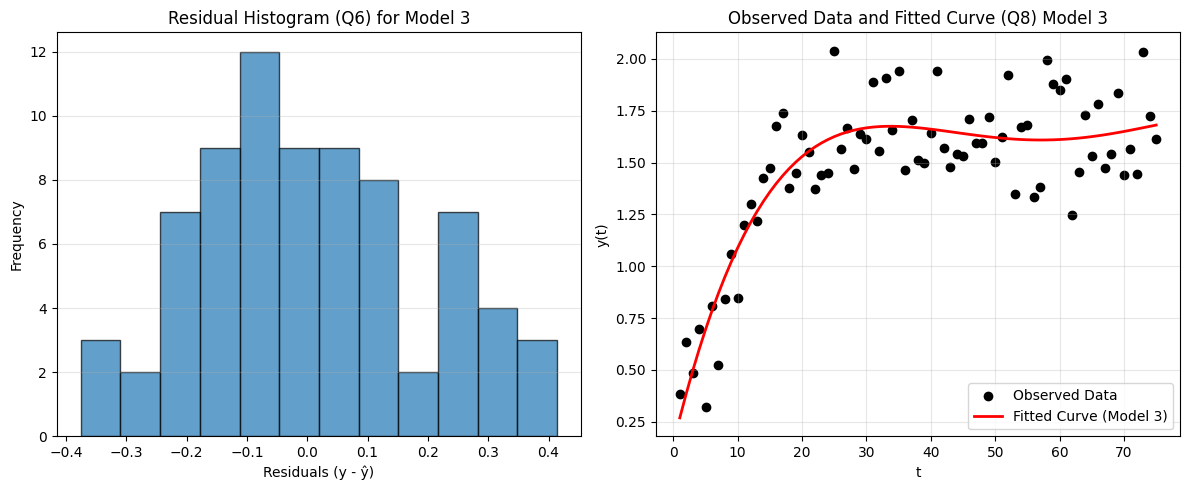

In [50]:
# Q6, Q8: Plots
plt.figure(figsize=(12, 5))

# Plot 1: Residual historgram
plt.subplot(1, 2, 1)
plt.hist(best_res, bins=12, edgecolor='black', alpha=0.7)
plt.title(f"Residual Histogram (Q6) for Model {best_model_num}")
plt.xlabel("Residuals (y - ŷ)")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.3)

# Plot 2: Data and Fitted Curve (Q8)
plt.subplot(1, 2, 2)
plt.scatter(t, y, label="Observed Data", color='black', marker='o')
plt.plot(t, best_y_pred, label=f"Fitted Curve (Model {best_model_num})", color='red', linewidth=2)
plt.title(f"Observed Data and Fitted Curve (Q8) Model {best_model_num}")
plt.xlabel("t")
plt.ylabel("y(t)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()